# HW3 Image Classification
## We strongly recommend that you run with Kaggle for this homework
https://www.kaggle.com/c/ml2022spring-hw3b/code?competitionId=34954&sortBy=dateCreated

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip /content/drive/MyDrive/food11.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: training/8_805.jpg      
  inflating: training/8_806.jpg      
  inflating: training/8_807.jpg      
  inflating: training/8_808.jpg      
  inflating: training/8_809.jpg      
  inflating: training/8_81.jpg       
  inflating: training/8_810.jpg      
  inflating: training/8_811.jpg      
  inflating: training/8_812.jpg      
  inflating: training/8_813.jpg      
  inflating: training/8_814.jpg      
  inflating: training/8_815.jpg      
  inflating: training/8_816.jpg      
  inflating: training/8_817.jpg      
  inflating: training/8_818.jpg      
  inflating: training/8_819.jpg      
  inflating: training/8_82.jpg       
  inflating: training/8_820.jpg      
  inflating: training/8_821.jpg      
  inflating: training/8_822.jpg      
  inflating: training/8_823.jpg      
  inflating: training/8_824.jpg      
  inflating: training/8_825.jpg      
  inflating: training/8_826.jpg      
  inflating: training/8_827.jpg      
  inflating: training/8_828.j

# Training

In [3]:
_exp_name = "sample"

In [4]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models
from PIL import Image
import matplotlib.pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [5]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [6]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229,0.224,0.225)),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.RandomInvert(0.1),
    transforms.RandomHorizontalFlip(0.25),
    transforms.RandomVerticalFlip(0.25),
    transforms.RandomApply(
        [transforms.RandomResizedCrop((128, 128),scale=(0.08, 1.0))],0.35
    ),
    transforms.RandomApply(
        [transforms.RandomRotation((0,360))],0.6
    ),
    transforms.RandomApply(
        [transforms.Pad(random.randint(0,50)),transforms.Resize((128, 128)),],0.4
    ),
    transforms.RandomEqualize(0.1),
    transforms.RandomGrayscale(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229,0.224,0.225)),
])


In [7]:
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img.permute(1,2,0)), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


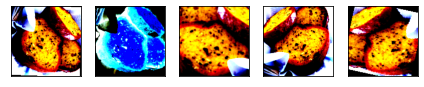

In [8]:
orig_img= Image.open('training/0_0.jpg')
padded_imgs = [train_tfm(orig_img) for padding in range(5)]
plot(padded_imgs)

## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [9]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None,test=False):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        # valid_path=os.path.join(_dataset_dir,"validation")
        # if not test:
        #   self.files += sorted([os.path.join(valid_path,x) for x in os.listdir(valid_path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label



In [10]:
class FoodDataset_resplit(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None,split=0,valid=False):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        valid_path=os.path.join(_dataset_dir,"validation")
        self.valid_files = [os.path.join(valid_path,x) for x in os.listdir(valid_path) if x.endswith(".jpg")]
        self.files=[[i for i in self.files if i.startswith(os.path.join(path,str(j)))] for j in range(11)]
        if valid:
          self.files=[i[split*len(i)//3:(split+1)*len(i)//3] for i in self.files]
          tmp=[]
          for j in self.files:
            for i in j:
              tmp.append(i)
          self.files=tmp
        else:
          self.files=[ i[:split*len(i)//3]+i[(split+1)*len(i)//3:]  for i in self.files]
          tmp=[]
          for j in self.files:
            for i in j:
              tmp.append(i)
          self.files=tmp
          self.files+=self.valid_files

        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label


In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 256, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]

            nn.Conv2d(512, 1024, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [12]:
class Classifier2(nn.Module):
    def __init__(self):
        super(Classifier2, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.pre = torchvision.models.resnet101(pretrained=False).to(device)
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.pre(x)
        # out = out.view(out.size()[0], -1)
        return self.fc(out)

In [13]:
class Classifier3(nn.Module):
    def __init__(self):
        super(Classifier3, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.pre = torchvision.models.vgg19_bn(pretrained=False).to(device)
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.pre(x)
        # out = out.view(out.size()[0], -1)
        return self.fc(out)

In [14]:
class Classifier4(nn.Module):
    def __init__(self):
        super(Classifier4, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.pre = torchvision.models.alexnet(pretrained=False).to(device)
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.pre(x)
        # out = out.view(out.size()[0], -1)
        return self.fc(out)

In [15]:
class Classifier5(nn.Module):
    def __init__(self):
        super(Classifier5, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.pre = torchvision.models.googlenet(pretrained=False).to(device)
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.pre(x)
        if type(out)!=type(torch.tensor(0)):
          out=out.logits
        # out = out.view(out.size()[0], -1)
        return self.fc(out)

In [16]:
class Classifier6(nn.Module):
    def __init__(self):
        super(Classifier6, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.pre = torchvision.models.densenet201(pretrained=False).to(device)
        self.fc = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.pre(x)
        # out = out.view(out.size()[0], -1)
        return self.fc(out)

In [17]:
batch_size = 128
_dataset_dir = ""
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=train_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One training sample training/0_0.jpg
One validation sample validation/0_0.jpg


In [28]:
batch_size = 128
_dataset_dir = ""
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
split=2

train_set = FoodDataset_resplit(os.path.join(_dataset_dir,"training"), tfm=train_tfm,split=split)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset_resplit(os.path.join(_dataset_dir,"training"), tfm=train_tfm,split=split,valid=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One training sample training/0_0.jpg
One training sample training/0_695.jpg


In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 3000
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = Classifier3().to(device)
#model=torchvision.models.efficientnet_b0(pretrained=False).to(device)
# model=torchvision.models.resnet101(pretrained=False).to(device)
model.load_state_dict(torch.load(f"/content/drive/MyDrive/best_vgg_norm.ckpt"))
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.00001) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0.75

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        break
    
    #The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"/content/drive/MyDrive/best_vgg_norm.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 001/3000 ] loss = 0.76120, acc = 0.75775


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 001/3000 ] loss = 0.88041, acc = 0.71875
[ Valid | 001/3000 ] loss = 0.88041, acc = 0.71875


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 002/3000 ] loss = 0.75741, acc = 0.75687


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 002/3000 ] loss = 0.78853, acc = 0.75781
[ Valid | 002/3000 ] loss = 0.78853, acc = 0.75781 -> best
Best model found at epoch 1, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 003/3000 ] loss = 0.74837, acc = 0.76458


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 003/3000 ] loss = 1.19866, acc = 0.65625
[ Valid | 003/3000 ] loss = 1.19866, acc = 0.65625


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 004/3000 ] loss = 0.72382, acc = 0.76781


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 004/3000 ] loss = 0.90903, acc = 0.69531
[ Valid | 004/3000 ] loss = 0.90903, acc = 0.69531


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 005/3000 ] loss = 0.73200, acc = 0.76723


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 005/3000 ] loss = 1.05829, acc = 0.65625
[ Valid | 005/3000 ] loss = 1.05829, acc = 0.65625


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 006/3000 ] loss = 0.70536, acc = 0.77009


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 006/3000 ] loss = 0.93797, acc = 0.67969
[ Valid | 006/3000 ] loss = 0.93797, acc = 0.67969


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 007/3000 ] loss = 0.71637, acc = 0.76693


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 007/3000 ] loss = 1.02949, acc = 0.64844
[ Valid | 007/3000 ] loss = 1.02949, acc = 0.64844


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 008/3000 ] loss = 0.72775, acc = 0.76693


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 008/3000 ] loss = 1.08704, acc = 0.66406
[ Valid | 008/3000 ] loss = 1.08704, acc = 0.66406


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 009/3000 ] loss = 0.72081, acc = 0.76777


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 009/3000 ] loss = 0.97630, acc = 0.67188
[ Valid | 009/3000 ] loss = 0.97630, acc = 0.67188


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 010/3000 ] loss = 0.70682, acc = 0.76707


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 010/3000 ] loss = 0.96236, acc = 0.69531
[ Valid | 010/3000 ] loss = 0.96236, acc = 0.69531


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 011/3000 ] loss = 0.73138, acc = 0.76112


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 011/3000 ] loss = 0.80060, acc = 0.72656
[ Valid | 011/3000 ] loss = 0.80060, acc = 0.72656


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 012/3000 ] loss = 0.70052, acc = 0.76993


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 012/3000 ] loss = 1.17468, acc = 0.67188
[ Valid | 012/3000 ] loss = 1.17468, acc = 0.67188


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 013/3000 ] loss = 0.69570, acc = 0.76911


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 013/3000 ] loss = 0.99217, acc = 0.66406
[ Valid | 013/3000 ] loss = 0.99217, acc = 0.66406


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 014/3000 ] loss = 0.70575, acc = 0.76641


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 014/3000 ] loss = 1.12495, acc = 0.64062
[ Valid | 014/3000 ] loss = 1.12495, acc = 0.64062


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 015/3000 ] loss = 0.69031, acc = 0.77658


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 015/3000 ] loss = 0.96029, acc = 0.71094
[ Valid | 015/3000 ] loss = 0.96029, acc = 0.71094


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 016/3000 ] loss = 0.69789, acc = 0.77638


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 016/3000 ] loss = 0.90365, acc = 0.72656
[ Valid | 016/3000 ] loss = 0.90365, acc = 0.72656


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 017/3000 ] loss = 0.68669, acc = 0.77660


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 017/3000 ] loss = 0.78796, acc = 0.78125
[ Valid | 017/3000 ] loss = 0.78796, acc = 0.78125 -> best
Best model found at epoch 16, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 018/3000 ] loss = 0.69785, acc = 0.77520


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 018/3000 ] loss = 1.06279, acc = 0.67969
[ Valid | 018/3000 ] loss = 1.06279, acc = 0.67969


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 019/3000 ] loss = 0.69814, acc = 0.77470


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 019/3000 ] loss = 1.14963, acc = 0.64062
[ Valid | 019/3000 ] loss = 1.14963, acc = 0.64062


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 020/3000 ] loss = 0.68807, acc = 0.77426


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 020/3000 ] loss = 0.87753, acc = 0.70312
[ Valid | 020/3000 ] loss = 0.87753, acc = 0.70312


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 021/3000 ] loss = 0.70790, acc = 0.77220


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 021/3000 ] loss = 1.02416, acc = 0.71094
[ Valid | 021/3000 ] loss = 1.02416, acc = 0.71094


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 022/3000 ] loss = 0.69692, acc = 0.77712


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 022/3000 ] loss = 0.98839, acc = 0.68750
[ Valid | 022/3000 ] loss = 0.98839, acc = 0.68750


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 023/3000 ] loss = 0.67742, acc = 0.77991


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 023/3000 ] loss = 1.10520, acc = 0.66406
[ Valid | 023/3000 ] loss = 1.10520, acc = 0.66406


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 024/3000 ] loss = 0.69107, acc = 0.77887


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 024/3000 ] loss = 1.03232, acc = 0.69531
[ Valid | 024/3000 ] loss = 1.03232, acc = 0.69531


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 025/3000 ] loss = 0.68037, acc = 0.78299


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 025/3000 ] loss = 1.06201, acc = 0.66406
[ Valid | 025/3000 ] loss = 1.06201, acc = 0.66406


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 026/3000 ] loss = 0.68191, acc = 0.78762


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 026/3000 ] loss = 0.89928, acc = 0.71875
[ Valid | 026/3000 ] loss = 0.89928, acc = 0.71875


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 027/3000 ] loss = 0.65920, acc = 0.78299


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 027/3000 ] loss = 0.59534, acc = 0.78906
[ Valid | 027/3000 ] loss = 0.59534, acc = 0.78906 -> best
Best model found at epoch 26, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 028/3000 ] loss = 0.64568, acc = 0.79363


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 028/3000 ] loss = 0.86263, acc = 0.70312
[ Valid | 028/3000 ] loss = 0.86263, acc = 0.70312


  0%|          | 0/78 [00:00<?, ?it/s]

In [38]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm,test=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_set2 = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm,test=True)
test_loader2 = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One test sample test/0001.jpg
One test sample test/0001.jpg


In [ ]:
device = "cuda"

# Testing and generate prediction CSV

In [41]:
model_best = Classifier2().to(device)
model_best.load_state_dict(torch.load(f"/content/drive/MyDrive/best_res1_norm.ckpt"))
model_best1 = Classifier2().to(device)
model_best1.load_state_dict(torch.load(f"/content/drive/MyDrive/best_res_norm.ckpt"))
model_best2 = Classifier2().to(device)
model_best2.load_state_dict(torch.load(f"/content/drive/MyDrive/best_res0_norm.ckpt"))
model_best3 = Classifier2().to(device)
model_best3.load_state_dict(torch.load(f"/content/drive/MyDrive/best_res2_norm.ckpt"))
model_best4 = Classifier3().to(device)
model_best4.load_state_dict(torch.load(f"/content/drive/MyDrive/best_vgg_norm.ckpt"))
model_best5 = Classifier3().to(device)
model_best5.load_state_dict(torch.load(f"/content/drive/MyDrive/best_vgg0_norm.ckpt"))
model_best6 = Classifier3().to(device)
model_best6.load_state_dict(torch.load(f"/content/drive/MyDrive/best_vgg1_norm.ckpt"))
model_best7 = Classifier3().to(device)
model_best7.load_state_dict(torch.load(f"/content/drive/MyDrive/best_vgg2_norm.ckpt"))


model_best.eval()
model_best1.eval()
model_best2.eval()
model_best3.eval()
model_best4.eval()
model_best5.eval()
model_best6.eval()
model_best7.eval()

train_nums=5
prediction = []
with torch.no_grad():
    test_pred=np.empty((0,11))
    for data,_ in test_loader:
      tmp=model_best(data.to(device))
      test_pred=np.concatenate([test_pred , tmp.cpu().data.numpy().squeeze()])
    for i in range(train_nums-1):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums

    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best1(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best1(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums

    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best2(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best2(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums

    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best3(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best3(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums

    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best4(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best4(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums
    
    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best5(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best5(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums
    
    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best6(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best6(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums
    
    for i in range(train_nums):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best7(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best7(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums


    
    test_label = np.argmax(test_pred, axis=1)
    prediction = test_label.squeeze().tolist()

0 (0, 11)
0 (128, 11)
0 (256, 11)
0 (384, 11)
0 (512, 11)
0 (640, 11)
0 (768, 11)
0 (896, 11)
0 (1024, 11)
0 (1152, 11)
0 (1280, 11)
0 (1408, 11)
0 (1536, 11)
0 (1664, 11)
0 (1792, 11)
0 (1920, 11)
0 (2048, 11)
0 (2176, 11)
0 (2304, 11)
0 (2432, 11)
0 (2560, 11)
0 (2688, 11)
0 (2816, 11)
0 (2944, 11)
0 (3072, 11)
0 (3200, 11)
0 (3328, 11)
1 (0, 11)
1 (128, 11)
1 (256, 11)
1 (384, 11)
1 (512, 11)
1 (640, 11)
1 (768, 11)
1 (896, 11)
1 (1024, 11)
1 (1152, 11)
1 (1280, 11)
1 (1408, 11)
1 (1536, 11)
1 (1664, 11)
1 (1792, 11)
1 (1920, 11)
1 (2048, 11)
1 (2176, 11)
1 (2304, 11)
1 (2432, 11)
1 (2560, 11)
1 (2688, 11)
1 (2816, 11)
1 (2944, 11)
1 (3072, 11)
1 (3200, 11)
1 (3328, 11)
2 (0, 11)
2 (128, 11)
2 (256, 11)
2 (384, 11)
2 (512, 11)
2 (640, 11)
2 (768, 11)
2 (896, 11)
2 (1024, 11)
2 (1152, 11)
2 (1280, 11)
2 (1408, 11)
2 (1536, 11)
2 (1664, 11)
2 (1792, 11)
2 (1920, 11)
2 (2048, 11)
2 (2176, 11)
2 (2304, 11)
2 (2432, 11)
2 (2560, 11)
2 (2688, 11)
2 (2816, 11)
2 (2944, 11)
2 (3072, 11)
2 (

In [39]:
model_best = Classifier2().to(device)
model_best.load_state_dict(torch.load(f"/content/drive/MyDrive/best_res1_norm.ckpt"))
model_best.eval()
train_nums=6
prediction = []
with torch.no_grad():
    test_pred=np.empty((0,11))
    for data,_ in test_loader:
      tmp=model_best(data.to(device))
      test_pred=np.concatenate([test_pred , tmp.cpu().data.numpy().squeeze()])
    for i in range(train_nums-1):
      test_pred2=np.empty((0,11))
      for data,_ in test_loader:
        print(i, test_pred2.shape)
        tmp=model_best(data.to(device))
        test_pred2=np.concatenate([test_pred2 , tmp.cpu().data.numpy().squeeze()])
      test_pred+=test_pred2
    test_pred3=np.empty((0,11)) 
    for data,_ in test_loader2:
      tmp=model_best(data.to(device))
      test_pred3=np.concatenate([test_pred3 , tmp.cpu().data.numpy().squeeze()])
    test_pred+=test_pred3*train_nums
    
    test_label = np.argmax(test_pred, axis=1)
    prediction = test_label.squeeze().tolist()

0 (0, 11)
0 (128, 11)
0 (256, 11)
0 (384, 11)
0 (512, 11)
0 (640, 11)
0 (768, 11)
0 (896, 11)
0 (1024, 11)
0 (1152, 11)
0 (1280, 11)
0 (1408, 11)
0 (1536, 11)
0 (1664, 11)
0 (1792, 11)
0 (1920, 11)
0 (2048, 11)
0 (2176, 11)
0 (2304, 11)
0 (2432, 11)
0 (2560, 11)
0 (2688, 11)
0 (2816, 11)
0 (2944, 11)
0 (3072, 11)
0 (3200, 11)
0 (3328, 11)
1 (0, 11)
1 (128, 11)
1 (256, 11)
1 (384, 11)
1 (512, 11)
1 (640, 11)
1 (768, 11)
1 (896, 11)
1 (1024, 11)
1 (1152, 11)
1 (1280, 11)
1 (1408, 11)
1 (1536, 11)
1 (1664, 11)
1 (1792, 11)
1 (1920, 11)
1 (2048, 11)
1 (2176, 11)
1 (2304, 11)
1 (2432, 11)
1 (2560, 11)
1 (2688, 11)
1 (2816, 11)
1 (2944, 11)
1 (3072, 11)
1 (3200, 11)
1 (3328, 11)
2 (0, 11)
2 (128, 11)
2 (256, 11)
2 (384, 11)
2 (512, 11)
2 (640, 11)
2 (768, 11)
2 (896, 11)
2 (1024, 11)
2 (1152, 11)
2 (1280, 11)
2 (1408, 11)
2 (1536, 11)
2 (1664, 11)
2 (1792, 11)
2 (1920, 11)
2 (2048, 11)
2 (2176, 11)
2 (2304, 11)
2 (2432, 11)
2 (2560, 11)
2 (2688, 11)
2 (2816, 11)
2 (2944, 11)
2 (3072, 11)
2 (

In [ ]:
model_best = Classifier2().to(device)
model_best.load_state_dict(torch.load(f"/content/drive/MyDrive/best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader2:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

In [42]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv("/content/drive/MyDrive/submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You need to add some transforms here.
    transforms.RandomInvert(0.2),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomApply(
        [transforms.RandomRotation((0,360))],0.5
    ),
    transforms.RandomApply(
        [transforms.Pad(random.randint(0,50)),transforms.Resize((128, 128)),],0.4
    ),
    transforms.RandomEqualize(0.2),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
])

# Q2. Residual Implementation
![](https://i.imgur.com/GYsq1Ap.png)
## Directly copy the following block and paste it on GradeScope after you finish the code


In [ ]:
from torch import nn
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256* 32* 32, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)
        
        x1 = self.relu(x1)
        
        x2 = self.cnn_layer2(x1)
        
        x2 = self.relu(x2)
        
        x3 = self.cnn_layer3(x2+x1)
        
        x3 = self.relu(x3)
        
        x4 = self.cnn_layer4(x3)
        
        x4 = self.relu(x4)
        
        x5 = self.cnn_layer5(x4+x3)
        
        x5 = self.relu(x5)
        
        x6 = self.cnn_layer6(x5)
        
        x6 = self.relu(x6)
        
        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = (x6+x5).flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout